# Ayudantía 7

In [2]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.linalg import hilbert

### SVD con algoritmos de valores propios

La descomposición SVD de $A$ tiene relación con la descomposición espectral de $A^*A$. En este sentido:

$$A^*A = P\Lambda P^* = V(\Sigma^*\Sigma)V^* = (V\Sigma^*U^*)(U\Sigma V^*)$$

Entonces, podemos calcular la descomposición SVD de $A$ calculando los valores propios de $A^*A$ de la siguiente forma:

1. Calcular $A^*A = V\Lambda V^*$
2. $\Sigma = +\sqrt{\Lambda}$ (componente a componente)
3. Resolver $U\Sigma = AV$ para alguna matriz $U$ unitaria.

Asumimos que $A$ es cuadrada. Existe una forma de encontrar su descomposición SVD de forma estable usando los valores propios, al contrario del procedimiento anterior que es inestable. Para esto, aplicamos los siguientes pasos a $A$:

- Bidiagonalización $B = Q^TAR$ donde $B$ es bidiagonal, y $Q^T, R$ se obtienen con reflectores de Householder.
- Armar:
$$H = \begin{bmatrix}0&B^*\\B&0\end{bmatrix}$$
- Resolver el problema de valores y vectores propios para la matriz $H$.

In [3]:
def form_H(A):
    m, n = A.shape
    H = np.zeros((m+n, m+n), dtype=float)
    H[:n, n:] = A.conj().T
    H[n:, :n] = A
    return H

def signo(x):
    if x >= 0:
        return 1
    return -1


def bidiagonalization(A):
    """
    Golub-Kahan Bidiagonalization
    Input: A matriz cuadrada
    Output:
            - B bidiagonal
            - QT unitaria
            - R unitaria
    tal que A = QT@B@R
    """
    
    m, n = A.shape
    B = np.copy(A)
    QT = np.identity(n, dtype=float)
    R = np.identity(n, dtype=float)
    
    for k in range(n):
        
        # Cambios en columna
        x = B[k:, k]
        Lx = x.shape[0]
        
        # v de la proyección householder
        v = x + signo(x[0])*np.linalg.norm(x, ord=2)*np.eye(1, M=Lx)[0]
        v = v/np.linalg.norm(v, ord=2)
        
        Pk = np.eye(Lx) - 2*np.outer(v, v)
        B[k:, k:] = Pk@B[k:, k:]
        
        P = np.eye(n)
        P[k:, k:] = Pk
        QT = QT@P
        
        if k < n-1:
            
            y = B[k, k+1:]
            Ly = y.shape[0]
            
            v = y + signo(y[0])*np.linalg.norm(y, ord=2)*np.eye(1, M=Ly)[0]
            v = v/np.linalg.norm(v, ord=2)
            
            Pk = np.eye(Ly) - 2*np.outer(v, v)
            
            B[k:, k+1:] = B[k:, k+1:]@Pk
            P = np.eye(n)
            P[k+1:, k+1:] = Pk
            R = P@R
        
    return QT, B, R

¿Quienes son entonces las matrices $U, \Sigma, V^T$ de la descomposición SVD de $B$? Tenemos que si $B=U_B\Sigma_B V_B^*$, entonces:

$$\begin{bmatrix}&B^*\\B&\end{bmatrix}\begin{bmatrix}V_B&V_B\\U_B&-U_B\end{bmatrix}=\begin{bmatrix}V_B&V_B\\U_B&-U_B\end{bmatrix}\begin{bmatrix}\Sigma_B&\\&-\Sigma_B\end{bmatrix}$$

Es decir, la matriz con $U_B$ y $V_B$ son los vectores propios de $H$, y la matriz con $\Sigma$'s son los valores propios de $H$.

In [16]:
def obtain_SVD(A):
    """
    B tiene mismos valores propios que A
    Input: A cuadrada
    Output: matrices U, S, VT tal que A = U*S@VT
    """
    QT, B, R = bidiagonalization(A)
    H = form_H(B)
    m, n = H.shape
    k = int(n/2)
    
    # Valores propios y vectores propios de H
    # Pueden obtenerse por otros algoritmos (Ejemplo: QR)
    print(np.round(H, 2))
    
    # H a tridiagonal Htri
    P = np.eye(n)
    perm_array = np.array([(i, i+k) for i in range(k)]).flatten()
    print(perm_array)
    P[:, np.arange(n)] = P[:, perm_array]
    Htri = P.T@H@P
    print(np.round(Htri,2))
    
    
    vals, vecs = np.linalg.eig(H)
    
    #Indices para ordenar
    sorted_indexes = np.argsort(vals)[::-1]
    sorted_indexes[k:] = sorted_indexes[k:][::-1]
    
    #print(vals)
    #print(sorted_indexes)
    
    #Ordenamiento
    vals = vals[sorted_indexes]
    #print(vals)
    vecs = vecs[:, sorted_indexes]
    
    # Armamos UB, VB, SB
    VB = np.sqrt(2)*vecs[:k, :k] #Necesitamos que sean unitarias
    UB = np.sqrt(2)*vecs[k:, :k] #Necesitamos que sean unitarias
    SB = vals[:k]
    
    print("Factorizamos bien?: ")
    print(np.allclose(B, UB*SB@VB.conj().T))
    print("B: ")
    print(np.round(B, 2))
    print("Producto SVD de B: ")
    print(np.round(UB*SB@VB.conj().T, 2))
    
    U = QT@UB
    VT = VB.conj().T@R
    Sigma = SB
    return U, Sigma, VT

In [17]:
A = np.array([[1., 2., 1.], [2., 1., 1.], [3., 1., 0.]])
U, Sigma, VT = obtain_SVD(A)

print(U*Sigma@VT)
print(np.linalg.svd(A)[0])

[[ 0.    0.    0.   -3.74 -0.   -0.  ]
 [ 0.    0.    0.    2.04 -1.85 -0.  ]
 [ 0.    0.    0.   -0.   -0.34 -0.58]
 [-3.74  2.04 -0.    0.    0.    0.  ]
 [-0.   -1.85 -0.34  0.    0.    0.  ]
 [-0.   -0.   -0.58  0.    0.    0.  ]]
[0 3 1 4 2 5]
[[ 0.   -3.74  0.   -0.    0.   -0.  ]
 [-3.74  0.    2.04  0.   -0.    0.  ]
 [ 0.    2.04  0.   -1.85  0.   -0.  ]
 [-0.    0.   -1.85  0.   -0.34  0.  ]
 [ 0.   -0.    0.   -0.34  0.   -0.58]
 [-0.    0.   -0.    0.   -0.58  0.  ]]
Factorizamos bien?: 
True
B: 
[[-3.74  2.04 -0.  ]
 [-0.   -1.85 -0.34]
 [-0.   -0.   -0.58]]
Producto SVD de B: 
[[-3.74  2.04  0.  ]
 [ 0.   -1.85 -0.34]
 [-0.    0.   -0.58]]
[[ 1.00000000e+00  2.00000000e+00  1.00000000e+00]
 [ 2.00000000e+00  1.00000000e+00  1.00000000e+00]
 [ 3.00000000e+00  1.00000000e+00 -1.86916418e-16]]
[[-0.47409445  0.79795882  0.37215076]
 [-0.55024641  0.06145095 -0.83273805]
 [-0.68735969 -0.5995711   0.40994042]]


In [18]:
A = hilbert(7)
U, Sigma, VT = obtain_SVD(A)

print(np.round(Sigma, 5))
print(np.round(np.linalg.svd(A)[1], 5))

[[ 0.    0.    0.    0.    0.    0.    0.   -1.23 -0.   -0.    0.   -0.
  -0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.    1.09  0.34 -0.   -0.    0.
  -0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.    0.11 -0.02 -0.   -0.
  -0.   -0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.   -0.    0.01  0.    0.
   0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.   -0.   -0.    0.    0.
   0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.   -0.   -0.    0.    0.
   0.    0.  ]
 [ 0.    0.    0.    0.    0.    0.    0.   -0.   -0.   -0.   -0.   -0.
   0.   -0.  ]
 [-1.23  1.09 -0.   -0.   -0.   -0.   -0.    0.    0.    0.    0.    0.
   0.    0.  ]
 [-0.    0.34  0.11 -0.   -0.   -0.   -0.    0.    0.    0.    0.    0.
   0.    0.  ]
 [-0.   -0.   -0.02  0.01 -0.   -0.   -0.    0.    0.    0.    0.    0.
   0.    0.  ]
 [ 0.   -0.   -0.    0.    0.    0.   -0.    0.    0.    0.    0.    0.
   0.    0.  ]
 [-0.    0.   -0.    0.    0.    0.   -0.  

### Métodos Iterativos (básicos) para sistemas lineales

Hay 3 que son los más básicos:
1. Jacobi
2. Gauss-Seidel
3. SOR

In [24]:
def decompose(A):
    """
    If A = D-E-F, 
    return matrices D, E, F
    """
    m, n = A.shape
    E, F = np.zeros_like(A), np.zeros_like(A)
    D = np.diag(A.diagonal())
    for i in range(m):
        for j in range(i):
            E[i, j] = -A[i, j]
        for j in range(i+1, n):
            F[i, j] = -A[i, j]
    return D, E, F

In [19]:
def Jacobi(A, b, tol=1e-14, x0=None):
    """
    Jacobi iteration to solve system Ax=b
    starting at x=x0.
    Default: x0 = 0.
    """
    m, n = A.shape
    D, E, F = decompose(A)
    
    #Jacobi Iteration matrix and vector
    B = np.linalg.inv(D)@(E + F)
    f = np.linalg.inv(D)@b
    
    #Initialization
    x = np.zeros(n, dtype=float)
    if x0 is not None:
        x = x0
    error = [np.linalg.norm(A@x-b)]
    
    #Iteration
    while error[-1] > tol:
        x = B@x + f
        error.append(np.linalg.norm(A@x - b))
    
    return x, error

def GaussSeidel(A, b, tol=1e-14, x0=None):
    """
    GS iteration to solve system Ax=b
    N iterations starting at x=x0
    Default: x0 = 0.
    """
    m, n = A.shape
    D, E, F = decompose(A)
    
    #GS iteration matrix and vector
    B = np.linalg.inv(D-E)@F
    f = np.linalg.inv(D-E)@b
    
    #Initialization
    x = np.zeros(n, dtype=float)
    if x0 is not None:
        x = x0
    error = [np.linalg.norm(A@x-b)]
    
    #Iteration
    while error[-1] > tol:
        x = B@x + f
        error.append(np.linalg.norm(A@x - b))
    
    return x, error

def SOR(A, b, w, x0=None, tol=1e-14):
    """
    SOR iteration to solve system Ax=b
    Starts at x0 = 0.
    Ends when |Ax-b| < tol.
    """
    m, n = A.shape
    D, E, F = decompose(A)
    
    # SOR iteration matrix and vector
    B = np.linalg.inv(D-w*E)@((1-w)*D + w*F)
    f = np.linalg.inv(D-w*E)@(w*b)
    
    # Initialization
    x = np.zeros(n, dtype=float)
    if x0 is not None:
        x = x0
    error = [np.linalg.norm(A@x - b)]
    
    while error[-1] > tol:
        x = B@x + f
        error.append(np.linalg.norm(A@x-b))
    return x, error

def omega_opt_SOR(A):
    D, E, F = decompose(A)
    BJ = np.linalg.inv(D)@(E + F) #Matriz iteracion Jacobi
    rJ = RadioEspectral(BJ)
    return 2./(1. + np.sqrt(1. - rJ**2))

def RadioEspectral(A):
    eigvals = np.linalg.eigvals(A)
    return max(abs(eigvals))

#### Ejemplo:
Tenemos que resolver el sistema:

$$\begin{cases}-u''(x) = 4\pi^2\sin(2\pi x),& x\in(0,1)\\
u(x) = 0,& x\in\{0,1\}
\end{cases}$$

Este sistema tiene como solución exacta:
$$u(x) = \sin(2\pi x)$$

Usaremos la aproximación de diferencias finitas para encontrar la solución!

In [20]:
def FD1D_System(n, f, uD):
    """
    Dados n puntos para discretizar el dominio (0, 1)
    (n+2) considerando el borde.
    f: función del lado derecho del laplaciano 1D
    uD: condicion de borde Dirichlet
    """
    h = 1./(n+1)
    
    #Matrix assembly
    A = np.zeros((n, n), dtype=float)
    for i in range(n):
        A[i, i] = 2.
    for i in range(1, n):
        A[i-1, i] = -1.
        A[i, i-1] = -1.
    
    # RHS vector
    points = np.linspace(0, 1, num=n+2)
    
    # Puntos interiores a secas
    b = (h**2)*np.array([f(x) for x in points[1:-1]])
    
    # Paso condición de borde al otro lado
    b[[0, n-1]] += np.array([uD(x) for x in [points[0], points[-1]]])
    
    return A, b

In [21]:
def plot_solution(n, f, uD, sol):
    A, b = FD1D_System(n, f, uD)
    # Para plotear solucion sistemas lineales
    t = np.linspace(0, 1, num=n+2)
    # Para plotear solucion real
    t_real = np.linspace(0, 1, num=1000)
    
    #Solucion invertir sistema
    uI = np.zeros(n+2, dtype=float)
    uI[0] = uD(t[0])
    uI[-1] = uD(t[-1])
    
    #Jacobi
    uJ = np.zeros(n+2, dtype=float)
    uJ[0] = uD(t[0])
    uJ[-1] = uD(t[-1])
    
    #GS
    uGS = np.zeros(n+2, dtype=float)
    uGS[0] = uD(t[0])
    uGS[-1] = uD(t[-1])
    
    #SOR
    w = omega_opt_SOR(A)
    uSOR = np.zeros(n+2, dtype=float)
    uSOR[0] = uD(t[0])
    uSOR[-1] = uD(t[-1])
    
    # Solutions
    uI[1:-1] = np.linalg.solve(A, b)
    uJ[1:-1], err_J = Jacobi(A, b) 
    uGS[1:-1], err_GS = GaussSeidel(A, b) 
    uSOR[1:-1], err_SOR = SOR(A, b, w) 
    
    fig, ax = plt.subplots(1, 2, figsize=(16, 8))
    
    ax[0].plot(t, uJ, label="Solución Jacobi")
    ax[0].plot(t, uGS, label="Solución GS")
    ax[0].plot(t, uSOR, label="Solución SOR")
    ax[0].plot(t, uI, label="Solución invertir matriz")
    ax[0].plot(t_real, sol(t_real), label="Solución analítica")
    ax[0].legend()
    ax[0].set_title(f"Soluciones n={n}")
    
    ax[1].plot(err_J, label="Error en Jacobi")
    ax[1].plot(err_GS, label="Error en GS")
    ax[1].plot(err_SOR, label="Error en SOR")
    ax[1].legend()
    ax[1].set_title("Error de métodos para convergencia")
    ax[1].set_yscale("log")
    #ax[1].set_xscale("log")
    plt.show()
    pass

#### Resolvemos

In [22]:
f = lambda x: 4*(np.pi**2)*np.sin(2*np.pi*x)
uD = lambda x: 0
sol = lambda x: np.sin(2*np.pi*x)

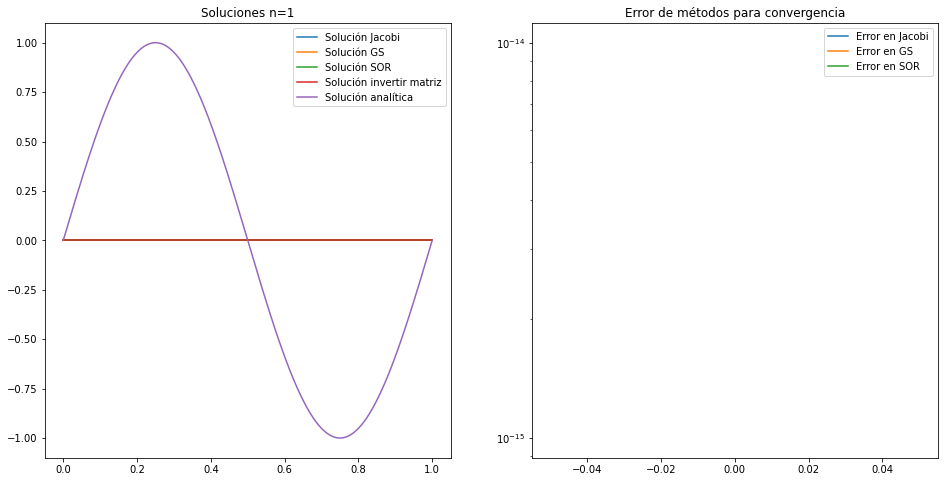

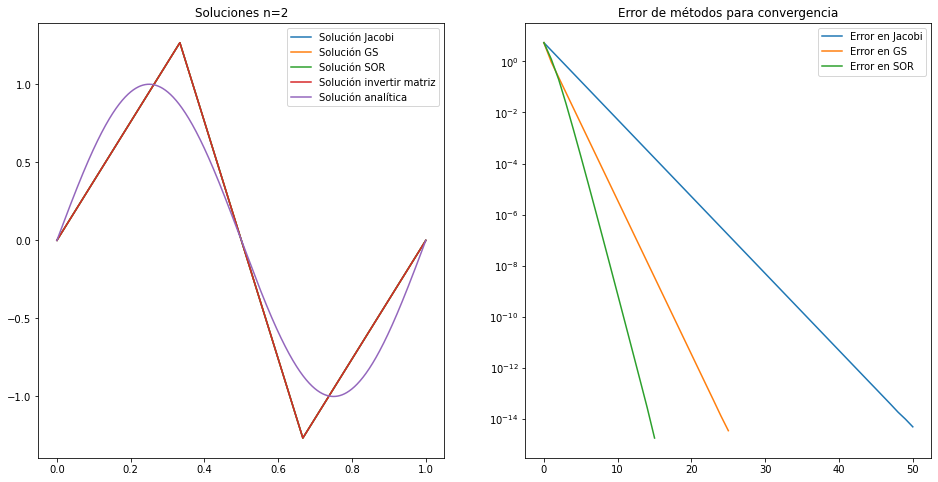

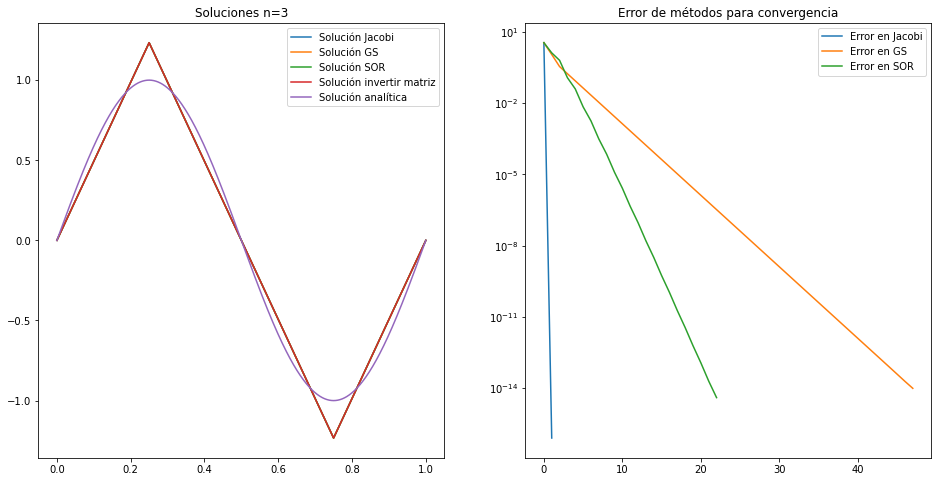

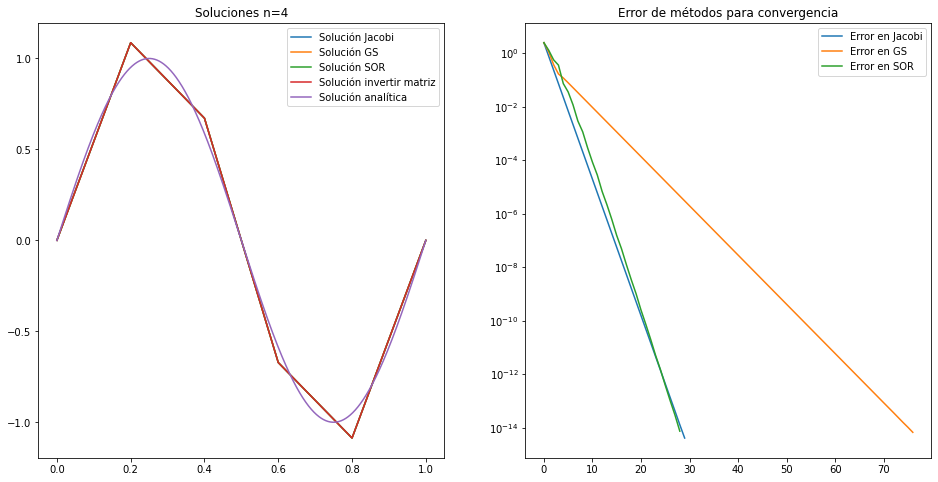

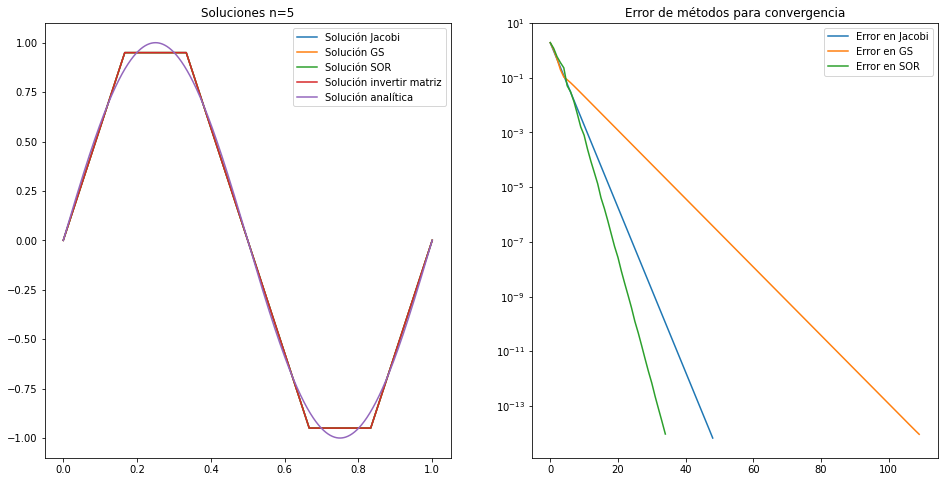

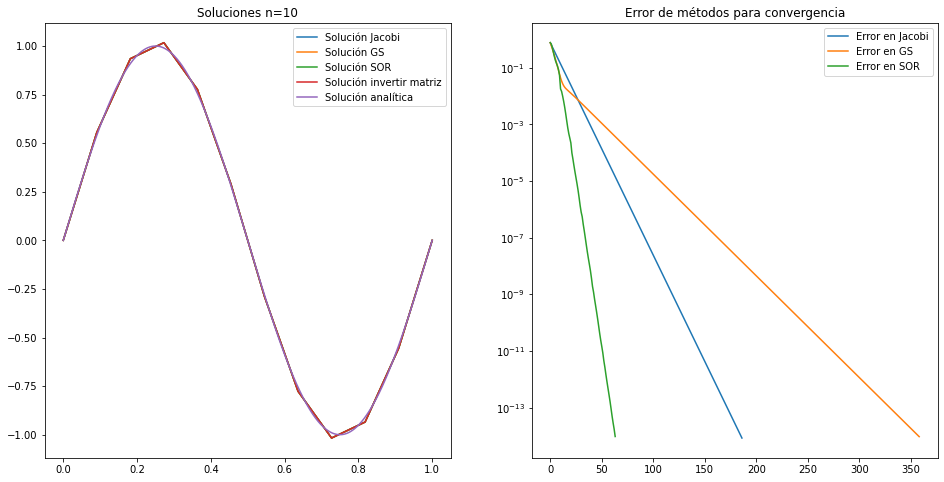

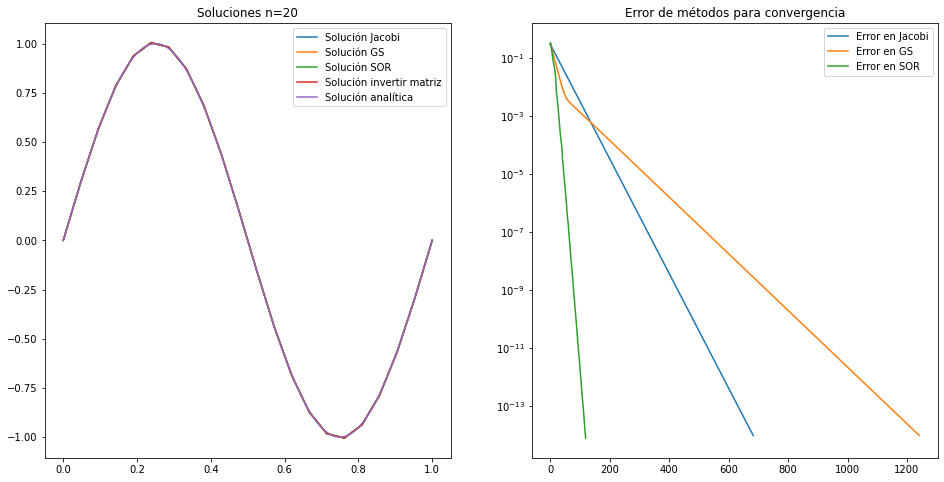

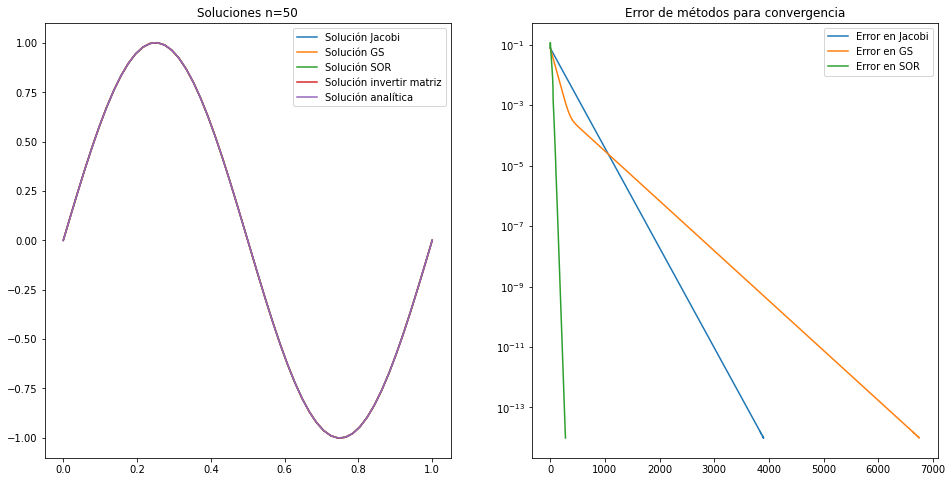

In [25]:
for n in [1, 2, 3, 4, 5, 10, 20, 50]:
    plot_solution(n, f, uD, sol)

### IMPORTANTE!

Los métodos iterativos de acá no aprovechan la estructura para resolver algún sistema en particular. Para diferencias finitas 1D y 2D es posible modificar estos métodos para que sea más eficiente resolver!